In [192]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
import matplotlib as mpl
from mplfinance.original_flavor import candlestick_ohlc
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import plot, iplot
import matplotlib.dates as dates
import datetime


In [193]:
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

In [202]:
class ichimoku():
    
    def __init__(self, instrument, source, started, end):
        self.df=data.DataReader(instrument, source, start, end)
        self._data = None
        self.instrument = instrument
        self._rangeselector = None

        self.df['Dates'] = dates.date2num(self.df.index)

        #Defining elements of ichimoku indicator
        period9_high = self.df['High'].rolling(window=9).max()
        period9_low = self.df['Low'].rolling(window=9).min()
        self.df['Tenkan-sen'] = (period9_high + period9_low) / 2

        period26_high = self.df['High'].rolling(window=26).max()
        period26_low =  self.df['Low'].rolling(window=26).min()
        self.df['Kijun-sen'] = (period26_high + period26_low) / 2

        self.df['Senkou-span_1'] = ((self.df['Tenkan-sen'] + self.df['Kijun-sen']) / 2).shift(26)

        period52_high = self.df['High'].rolling(window=52).max()
        period52_low = self.df['Low'].rolling(window=52).min()
        self.df['Senkou-span_2'] = ((period52_high + period52_low) / 2).shift(26)

        self.df['Chikou-span'] = self.df['Close'].shift(-26)

    
    @property
    def data(self):
        if self._data is None:
            #candlestick chart data for our first series to plot
            #also is the candlestick element itself
            self._data = [{
            'type' : 'candlestick',
            'open' : self.df.Open,
            'high' : self.df.High,
            'low' : self.df.Low,
            'close' : self.df.Close,
            'x' : self.df.index,
            'yaxis' : 'y2',
            'name' : self.instrument,
        }]
        return self._data

    @property
    def rangeselector(self):
        #populate the rangeselector object with necessary settings
        if self._rangeselector == None:
            rangeselector = {   
            'visible' : True,
            'x' : 0, 'y' : 0.9,
            'bgcolor' : 'rgba(148, 152, 161, 0.4)',
            'font' : {'size' : 13},
            'buttons' : [
                {'count' : 1, 'label' : 'reset', 'step' : 'all'},
                {'count' : 1, 'label' : '1yr', 'step' : 'year', 'stepmode' : 'backward'},
                {'count' : 3, 'label' : '3 mo', 'step' : 'month', 'stepmode' : 'backward'},
                {'count' : 1, 'label' : '1 mo', 'step' : 'month', 'stepmode' : 'backward'},
                {'step' : 'all'},
            ]
            }
        return self._rangeselector


    def fig(self):
                #main chart fig consists of data and layout settings
        fig = {'data' : self.data, 'layout' : dict() }
        # Assign various seeting and choices - background colour, range selector etc
        fig['layout']['plot_bgcolor'] = 'rgb(44, 48, 56)'
        fig['layout']['xaxis'] = {'rangeselector' : {'visible' : True}}
        fig['layout']['yaxis'] = {
                        'domain' : [0, 0.2], 
                        'showticklabels' : False 
                                }
        fig['layout']['yaxis2'] = {'domain' : [0.2, 0.8]}
        fig['layout']['legend'] = {
                        'orientation' : 'h',
                        'y' : 0.9,
                        'x' : 0.3, 
                        'yanchor' : 'bottom' 
                                    }
        fig['layout']['margin'] = {
                        't' : 40,
                        'b' : 40,
                        'r' : 40,
                        'l' : 40
                                    }      
        fig['layout']['xaxis']['rangeselector'] = self.rangeselector

        #append the ichimoku elements to the plot
        fig['data'].append({
                        'x' : self.df['Tenkan-sen'].index, 'y' : self.df['Tenkan-sen'],
                        'type' : 'scatter',
                        'mode' : 'lines',
                        'line' : {'width' : 1},
                        'marker' : {'color' : '#de7b12'},
                        'yaxis' : 'y2', 'name' : 'Tenkan-sen'
                            })
        fig['data'].append( {
                        'x' : self.df['Kijun-sen'].index, 'y' : self.df['Kijun-sen'],
                        'type' : 'scatter', 'mode' : 'lines',
                        'line' : {'width' : 1},
                        'marker' : {'color' : '#1245de'},
                        'yaxis' : 'y2', 'name' : 'Kijun-sen'
            })
        fig['data'].append({
                        'x' : self.df['Senkou-span_1'].index, 'y' : self.df['Senkou-span_1'],
                        'type' : 'scatter', 'mode' : 'lines',
                        'line' : {'width' : 1},
                        'marker' : {'color' : '#228B22'},
                        'yaxis' : 'y2', 'name' : 'Senkou-span 1'
        })                   
        fig['data'].append({
                        'x' : self.df['Senkou-span_2'].index, 'y' : self.df['Senkou-span_2'],
                        'type' : 'scatter', 'mode' : 'lines',
                        'line' : {'width' : 1}, 'fill' : "tonexty",
                        'marker' : {'color' : '#FF3341'},
                        'yaxis' : 'y2', 'name' : 'Senkou-span 2'
        })        
        fig['data'].append({
                        'x' : self.df['Chikou-span'].index, 'y' : self.df['Chikou-span'],
                        'type' : 'scatter', 'mode' : 'lines',
                        'line' : {'width' : 1},
                        'marker' : {'color' : '#046e08'},
                        'yaxis' : 'y2', 'name' : 'Chikou-span-span 1'
        })        
        return fig

    def chart(self):
        iplot(self.fig(), filename = 'candlestick-ichimoku' )


    def _dropnans(self):
        columns = self.df.columns.to_list()
        columns.remove('Chikou-span')
        self.df.dropna(inplace=True, subset=columns) 
        #in the code from pythonforfinance we use .dropna() without
        #selecting subsets, what causes to drop last 26 prices
        #in case when we selected end date as today/more recent date
        #it is a thing because chikou-span is price shifted 26 periods backwards,
        #so it has N/A values in most recent dates


    def _cloud_check(self):
        #now we will do two checks:
        #first - to check if the price is above cloud, we will set value as 1 if so,
        #second- to check if the price is below cloud, we will set value as -1 if so,
        #we can't do it in a single check because price can be in cloud, then it'll be 0
        self.df['above_cloud'] = 0
        
        self.df['above_cloud'] = np.where((self.df['Low'] > self.df['Senkou-span_1']) &
        (self.df['Low'] > self.df['Senkou-span_2']), 1, self.df['above_cloud'])

        self.df['above_cloud'] = np.where((self.df['High'] < self.df['Senkou-span_1']) &
        (self.df['Close'] < self.df['Senkou-span_2']), -1, self.df['above_cloud'])

        self.df['green_cloud'] = np.where((self.df['Senkou-span_1'] > self.df['Senkou-span_2']), 1, -1)


    def _price_check(self):
        #original code from the blog, we will try .shift(-1) instead of .shift(1) in next version of the code
        #gold_cross is substitute of "tenkan_kiju_cross" from original code,
        #  i named it like that to follow the Hosoda's nomenclature
        #gold cross is kiju
        self.df['gold_cross'] = np.NaN
        self.df['gold_cross'] = np.where(
            (self.df['Tenkan-sen'].shift(1) <= self.df['Kijun-sen'].shift(1)) 
            & 
            (self.df['Tenkan-sen'] > self.df['Kijun-sen']),
            1, self.df['gold_cross']
        )
        self.df['gold_cross'] = np.where(
            (self.df['Tenkan-sen'].shift(1) >= self.df['Kijun-sen'].shift(1))
            &
            (self.df['Tenkan-sen'] < self.df['Kijun-sen']),
            -1, self.df['gold_cross']) #criteria of closing position
        self.df['price_tenkan_cross'] = np.NaN
        self.df['price_tenkan_cross'] = np.where(
            (self.df['Open'].shift(1) <= self.df['Tenkan-sen'].shift(1))
            &
            (self.df['Open'] > self.df['Tenkan-sen']),
            1, self.df['price_tenkan_cross'])
        self.df['price_tenkan_cross'] = np.where(
            (self.df['Open'].shift(1) >= self.df['Tenkan-sen'].shift(1))
            &
            (self.df['Open'] < self.df['Tenkan-sen']),
            -1, self.df['price_tenkan_cross'])

    
    def _strategy_logic(self):
        #creation of actual buy and sell entry signals
        self.df['buy'] = np.NaN  #np.NAN only as a placeholder.
        #placeholder will not change unless first two criteria
        #and at least one of the last 2 criterias are met
        self.df['buy'] = np.where(
            (self.df['above_cloud'].shift(1) == 1) & (self.df['green_cloud'].shift(1) == 1)
            & 
            ((self.df['gold_cross'].shift(1) == 1) | (self.df['price_tenkan_cross'].shift(1) == 1))
            , 1, self.df['buy']
            )

        self.df['buy'] = np.where(self.df['gold_cross'].shift(-1) == -1, 0, self.df['buy'])
        self.df['buy'].ffill(inplace=True)

        self.df['sell'] = np.NaN
        self.df['sell'] = np.where(
            (self.df['above_cloud'].shift(1) == -1) & (self.df['green_cloud'].shift(1) == -1)
            & 
            ((self.df['gold_cross'].shift(1) == -1) | (self.df['price_tenkan_cross'].shift(1) == -1)),
            -1, self.df['sell'])
        self.df['sell'] = np.where(self.df['gold_cross'].shift(-1) == 1, 0, self.df['sell'])
        self.df['sell'].ffill(inplace=True)
        self.df['position'] = self.df['buy'] + self.df['sell']

    def efficiency_evaluation(self):
        self._dropnans()
        self._cloud_check()
        self._price_check()
        self._strategy_logic()
        #below code checks the returns of stock itself and the strategy
        self.df['stock_returns'] = np.log(self.df['Open']) - np.log(self.df['Open'].shift(1))
        self.df['strategy_returns'] = self.df['stock_returns'] * self.df['position']
        self.df[['stock_returns','strategy_returns']].cumsum().plot(figsize=(15,8))

In [204]:

ford = ichimoku('F', 'yahoo', start, end)


In [196]:
ford.chart()

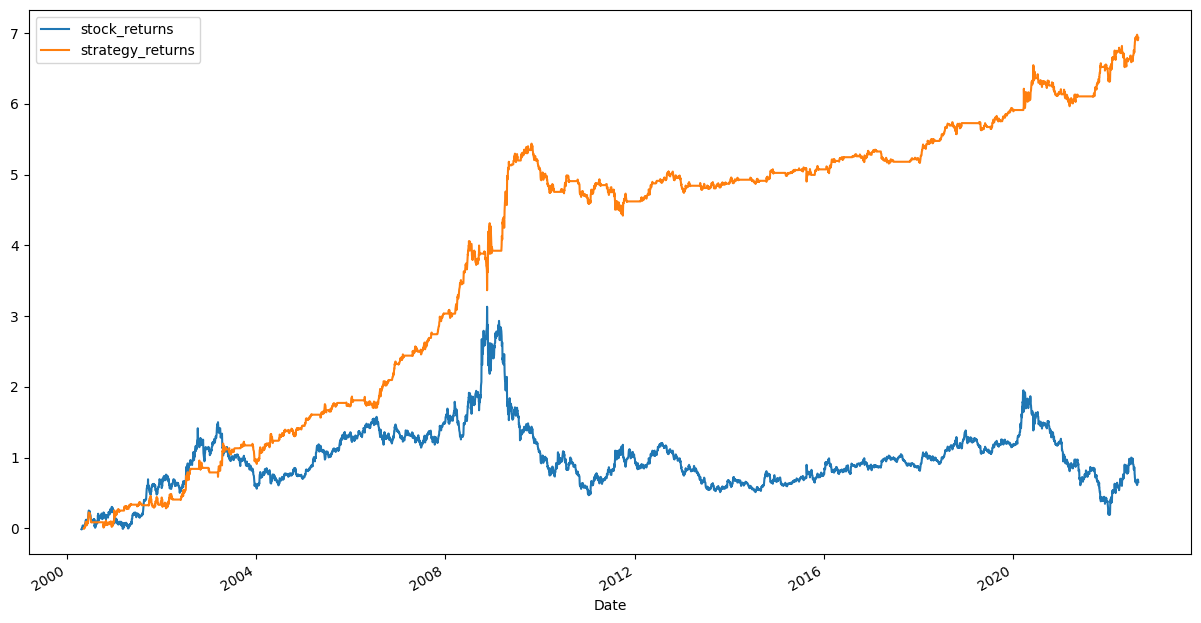

In [205]:
ford.efficiency_evaluation()

In [198]:
#set colour list for candlesticks
"""colors = []
for i in range(len(df.Close)):
    if i != 0:
        if df.Close[1] > df.Close[i-1]:
            colors.append(INCREASING_COLOR)
        else:
            colors.append(DECREASING_COLOR)
    else:
        colors.append(DECREASING_COLOR)
""" #i wonder what's a purpose of this


'colors = []\nfor i in range(len(df.Close)):\n    if i != 0:\n        if df.Close[1] > df.Close[i-1]:\n            colors.append(INCREASING_COLOR)\n        else:\n            colors.append(DECREASING_COLOR)\n    else:\n        colors.append(DECREASING_COLOR)\n'

,High,Low,Open,Close,Volume,Adj Close,Dates,Tenkan-sen,Kijun-sen,Senkou-span_1,...,Chikou-span,above_cloud,green_cloud,gold_cross,price_tenkan_cross,buy,sell,position,stock_returns,strategy_returns
Date,,,,,,,,,,,,,,,,,,,,,
2000-04-24,30.568415,29.881483,30.053217,30.396683,5555510.0,15.721731,11071.0,29.538018,27.477226,23.716281,...,26.687256,1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-25,30.465376,30.053217,30.431028,30.224949,5792069.0,15.632918,11072.0,29.538018,27.477226,23.870841,...,27.202454,1,-1,NaN,NaN,NaN,NaN,NaN,0.012493,NaN
2000-04-26,30.499722,29.744097,30.259295,30.224949,7072220.0,15.632918,11073.0,29.538018,27.477226,23.862254,...,26.584215,1,-1,NaN,NaN,NaN,NaN,NaN,-0.005659,NaN
2000-04-27,30.293642,29.400633,30.121908,30.293642,8152206.0,15.668445,11074.0,29.538018,27.614613,23.853667,...,27.958078,1,-1,NaN,NaN,NaN,NaN,NaN,-0.004551,NaN
2000-04-28,30.224949,29.675404,30.224949,30.087563,5705452.0,15.704293,11075.0,30.018869,27.734825,23.819321,...,27.477226,1,-1,NaN,NaN,NaN,NaN,NaN,0.003415,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-19,16.139999,15.770000,15.950000,15.880000,48519100.0,15.880000,19223.0,15.915000,14.085000,11.712500,...,NaN,1,-1,NaN,1.0,0.0,-1.0,-1.0,-0.002505,0.002505
2022-08-22,15.210000,14.910000,15.080000,15.080000,71321800.0,15.080000,19226.0,15.795000,14.290000,11.742500,...,NaN,1,-1,NaN,NaN,0.0,-1.0,-1.0,-0.056089,0.056089
2022-08-23,15.420000,15.090000,15.090000,15.320000,51289000.0,15.320000,19227.0,15.795000,14.445000,11.822500,...,NaN,1,-1,NaN,NaN,0.0,-1.0,-1.0,0.000663,-0.000663


,High,Low,Open,Close,Volume,Adj Close,Dates,Tenkan-sen,Kijun-sen,Senkou-span_1,...,Chikou-span,above_cloud,green_cloud,gold_cross,price_tenkan_cross,buy,sell,position,stock_returns,strategy_returns
Date,,,,,,,,,,,,,,,,,,,,,
2000-04-24,30.568415,29.881483,30.053217,30.396683,5555510.0,15.721731,11071.0,29.538018,27.477226,23.716281,...,26.687256,1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-25,30.465376,30.053217,30.431028,30.224949,5792069.0,15.632918,11072.0,29.538018,27.477226,23.870841,...,27.202454,1,-1,NaN,NaN,NaN,NaN,NaN,0.012493,NaN
2000-04-26,30.499722,29.744097,30.259295,30.224949,7072220.0,15.632918,11073.0,29.538018,27.477226,23.862254,...,26.584215,1,-1,NaN,NaN,NaN,NaN,NaN,-0.005659,NaN
2000-04-27,30.293642,29.400633,30.121908,30.293642,8152206.0,15.668445,11074.0,29.538018,27.614613,23.853667,...,27.958078,1,-1,NaN,NaN,NaN,NaN,NaN,-0.004551,NaN
2000-04-28,30.224949,29.675404,30.224949,30.087563,5705452.0,15.704293,11075.0,30.018869,27.734825,23.819321,...,27.477226,1,-1,NaN,NaN,NaN,NaN,NaN,0.003415,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-19,16.139999,15.770000,15.950000,15.880000,48519100.0,15.880000,19223.0,15.915000,14.085000,11.712500,...,NaN,1,-1,NaN,1.0,0.0,-1.0,-1.0,-0.002505,0.002505
2022-08-22,15.210000,14.910000,15.080000,15.080000,71321800.0,15.080000,19226.0,15.795000,14.290000,11.742500,...,NaN,1,-1,NaN,NaN,0.0,-1.0,-1.0,-0.056089,0.056089
2022-08-23,15.420000,15.090000,15.090000,15.320000,51289000.0,15.320000,19227.0,15.795000,14.445000,11.822500,...,NaN,1,-1,NaN,NaN,0.0,-1.0,-1.0,0.000663,-0.000663


SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (2783876386.py, line 1)